(500, 500, 3)


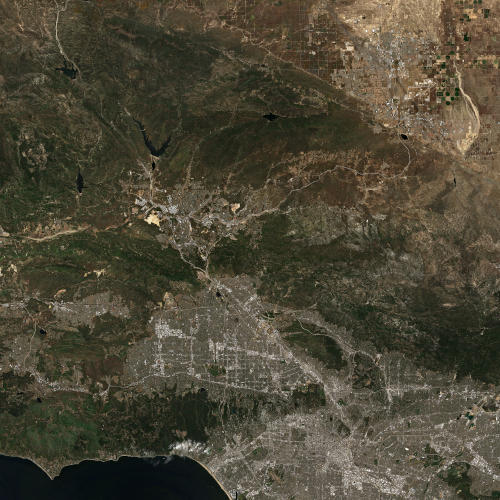

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("data.png")
data = np.array(image)[:, :, :3].astype(np.float) / 255
print(data.shape)
image

In [2]:
def isodata(data: np.ndarray,
            initial_clusters,
            min_samples_per_cluster,
            max_iterations,
            max_stddev,
            min_cluster_distance,
            max_merges):
    original_shape = data.shape
    d = data.shape[-1]
    data = data.reshape(-1, d) # (N, d)
    num_samples = len(data)
    # (1)
    means = data[np.random.randint(0, num_samples, initial_clusters)] # (k, d)
    k = len(means)
    print(f"Starting with {k} clusters")
    
    for iteration in range(1, max_iterations+1):
        print(f"Iteration {iteration}, k={k}:")
        # (2)
        distances = np.linalg.norm(data[:, np.newaxis] - means[np.newaxis], axis=2)
        assert distances.shape == (num_samples, k)
        assignments = np.argmin(distances, axis=1)
        assert assignments.shape == (num_samples,)
        
        yield assignments.reshape(original_shape[:-1]), means
        
        # (3) and (4)
        entries_per_class = np.bincount(assignments, minlength=k)
        means = np.stack([np.mean(data[assignments == i], axis=0)
                          for i in range(k)
                          if entries_per_class[i] >= min_samples_per_cluster], axis=0)
        if len(means) != k:
            print(f"Filtered {k - len(means)} classes for having too few items")
            k = len(means)
            continue
        
        assert all(entries_per_class >= min_samples_per_cluster)
        assert len(means) == k == len(entries_per_class)
        
        # (5)
        class_mean_distance_to_center = np.array([np.mean(np.linalg.norm(data[assignments == i] - means[i], axis=1))
                                                  for i in range(k)])
        mean_distance_to_center = np.mean(class_mean_distance_to_center * entries_per_class / num_samples)
        
        # (6)
        means = list(means)
        if iteration == max_iterations or (
            k > 0.5 * initial_clusters and (
                iteration % 2 == 0 or k >= 2 * initial_clusters
            )
        ):
            print(f"Skipping split")
            if iteration == max_iterations:
                min_cluster_distance = 0
        else:
            # (7)
            std_devs = np.stack([np.std(data[assignments == i] - means[i], axis=0)
                                for i in range(k)], axis=0)
            assert std_devs.shape == (k, d)
            jmax = np.argmax(std_devs, axis=1)

            # (8)
            old_k = k
            for i in range(k):
                if std_devs[i, jmax[i]] > max_stddev and (
                    (class_mean_distance_to_center[i] > mean_distance_to_center and
                     entries_per_class[i] > 2 * (min_samples_per_cluster + 1)) or
                    k <= initial_clusters / 2
                ):
                    print(f"Splitting a class because of maximum stddev")
                    new_mean = means[i].copy()
                    means[i][jmax[i]] -= std_devs[i, jmax[i]]
                    new_mean[jmax[i]] += std_devs[i, jmax[i]]
                    means.append(new_mean)
                    k += 1
            if k != old_k:
                means = np.asarray(means)
                continue
        
        # (9)
        intercluster_distances = [((i, j), np.linalg.norm(means[i] - means[j]))
                                  for i in range(k)
                                  for j in range(i)]
        
        # (10)
        intercluster_distances.sort(key=lambda x: x[1])
        involved_in_merges = set()
        for (i, j), distance in intercluster_distances[:max_merges]:
            if distance >= min_cluster_distance:
                break
            if i in involved_in_merges or j in involved_in_merges:
                continue
            print(f"Merging two classes because of minimum distance")
            involved_in_merges.add(i)
            involved_in_merges.add(j)
            n1 = entries_per_class[i]
            n2 = entries_per_class[j]
            means.append((n1 * means[i] + n2 * means[j])/(n1 + n2))
        
        for i in sorted(involved_in_merges, reverse=True):
            del means[i]
        k = len(means)
        means = np.asarray(means)
    
    # Final assignment, same as (2):
    distances = np.linalg.norm(data[:, np.newaxis] - means[np.newaxis], axis=2)
    assignments = np.argmin(distances, axis=1)
    yield assignments.reshape(original_shape[:-1]), means


Starting with 8 clusters
Iteration 1, k=8:
Filtered 2 classes for having too few items
Iteration 2, k=6:
Skipping split
Iteration 3, k=6:
Iteration 4, k=6:
Skipping split
Iteration 5, k=6:
Iteration 6, k=6:
Skipping split
Iteration 7, k=6:
Iteration 8, k=6:
Skipping split
Iteration 9, k=6:
Iteration 10, k=6:
Skipping split
Iteration 11, k=6:
Iteration 12, k=6:
Skipping split
Iteration 13, k=6:
Iteration 14, k=6:
Skipping split
Iteration 15, k=6:
Skipping split


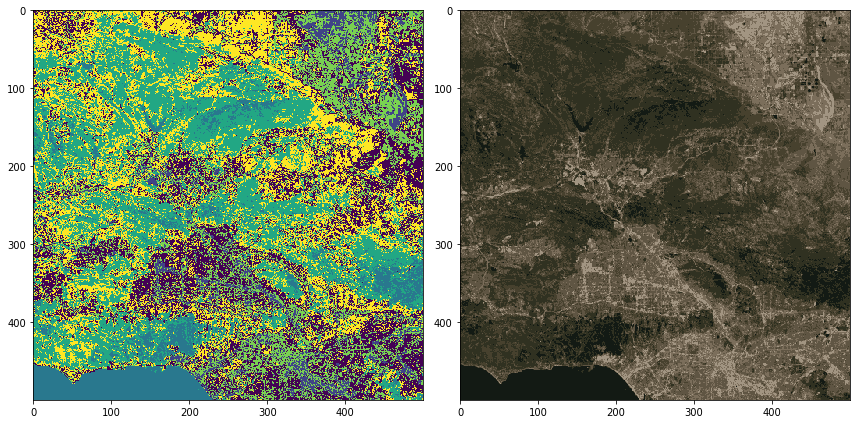

In [4]:
import matplotlib
from matplotlib import animation
from IPython.display import HTML
matplotlib.rcParams['animation.html'] = 'html5'

iterations = 15
algorithm = isodata(data,
                    initial_clusters=8,
                    min_samples_per_cluster=5000,
                    max_iterations=iterations,
                    max_stddev=0.1,
                    min_cluster_distance=0.1,
                    max_merges=4)
# Image.fromarray(mod_image)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
plot1 = ax1.imshow(np.zeros((data.shape[0], data.shape[1]), int))
plot2 = ax2.imshow(data)
fig.tight_layout()
assignments, means = None, None

def draw(i):
    global assignments, means
    assignments, means = next(algorithm, (assignments, means))
    plot1.set_clim(vmax=assignments.max())
    plot1.set_data(assignments)
    plot2.set_data(means[assignments])
    return plot1, plot2

animation.FuncAnimation(fig, draw, frames=iterations, interval=200, blit=False)

In [5]:
from IPython.display import Markdown

color_chip_bkg_css = """
display: inline-block;
padding: 0 0 0 14px;
height: 28px;
line-height: 28px;
border-radius: 14px;
background-color: #f1f1f1;
""".replace("\n", "")
color_chip_css = """
float: right;
margin: 0 0 0 5px;
height: 28px;
width: 28px;
border-radius: 50%;
background-color: #<color>;
""".replace("\n", "")

def color_chip(color):
    rgb = np.array(color * 255, int)
    code = "".join(f"{c:02X}" for c in rgb)
    return f'<div style="{color_chip_bkg_css}">RGB({rgb[0]},{rgb[1]},{rgb[2]})' \
           f'<div style="{color_chip_css.replace("<color>", code)}"></div></div>'

markdown = """| Class | num of points | coverage (%) | mean color |
              | ----- | ------------- | ------------ | ---------- |\n"""
plot_colors = plt.get_cmap()(np.linspace(0, 1, len(means)))[:, :3]
counts = np.bincount(assignments.reshape(-1), minlength=len(means))
num_points = data.shape[0] * data.shape[1]

for i in range(len(means)):
    markdown += f'| {color_chip(plot_colors[i])} | {counts[i]:,} | {counts[i] / num_points:.1%} | {color_chip(means[i])} |\n'
Markdown(markdown)

| Class | num of points | coverage (%) | mean color |
              | ----- | ------------- | ------------ | ---------- |
| <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(68,1,84)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #440154;"></div></div> | 56,022 | 22.4% | <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(95,85,67)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #5F5543;"></div></div> |
| <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(64,67,135)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #404387;"></div></div> | 11,422 | 4.6% | <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(162,149,130)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #A29582;"></div></div> |
| <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(41,120,142)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #29788E;"></div></div> | 18,651 | 7.5% | <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(19,26,20)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #131A14;"></div></div> |
| <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(34,167,132)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #22A784;"></div></div> | 70,390 | 28.2% | <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(48,49,33)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #303121;"></div></div> |
| <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(121,209,81)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #79D151;"></div></div> | 30,870 | 12.3% | <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(123,110,91)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #7B6E5B;"></div></div> |
| <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(253,231,36)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #FDE724;"></div></div> | 62,645 | 25.1% | <div style="display: inline-block;padding: 0 0 0 14px;height: 28px;line-height: 28px;border-radius: 14px;background-color: #f1f1f1;">RGB(71,65,46)<div style="float: right;margin: 0 0 0 5px;height: 28px;width: 28px;border-radius: 50%;background-color: #47412E;"></div></div> |
